# SAT Optics Simulation: Near-field

This notebook shows the optical path of the Simons Observatory SAT optics tube.  The ray-trace produces the electric field at the window (opening) of the SAT, which is in the near-field.  This field is convolved with a square to reproduce holography measurements, since the holography source emits its signal out of a rectangular feedhorn. 

Grace E. Chesmore
March 2022

### Optical Path
We first ray-trace from the focal plane through the 3 lenses, and out to 300mm in front of the window.  The $\verb|tele_geo.y_source|$ variable changes the plane of the rays in front of the window, since this is where the holography source will eventually scan. 

The $\verb|ray_trace.rx_to_lyot|$ outputs the amplitude and pathlength $d_{\text{PL}}$ of the rays in front of the window.  The pathlength information can be converted to phase $\phi$ due to the relationship:
$$ \phi = d_{\text{PL}} \frac{\lambda}{2\pi}$$

  0%|          | 0/10000 [00:00<?, ?it/s]/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ot_geo.py:65: RuntimeWarning: invalid value encountered in sqrt
  amp = (c * r ** 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ot_geo.py:107: RuntimeWarning: invalid value encountered in sqrt
  coeff_2 = (c * 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ot_geo.py:109: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2))
/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ot_geo.py:110: RuntimeWarning: invalid value encountered in sqrt
  * (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2))) ** 2
/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ray_trace.py:14: RuntimeWarning: invalid value encountered in sqrt
  s2 = (n1 / n2) * np.cross(N_surf, (np.cross(-N_surf, s1))) - N_surf * np.sqrt(

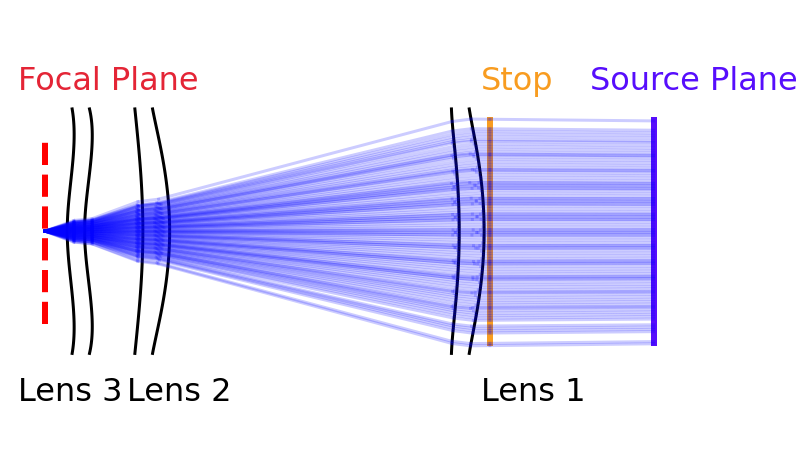

In [4]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sosat_optics
from sosat_optics import ot_geo, ray_trace, opt_analyze

matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams.update(
    {
        "axes.grid": False,
        "grid.color": "grey",
        "grid.alpha": 0.2,
        "xtick.direction": "in",
        "ytick.direction": "in",
    }
)

red = '#e42536'
blue = '#570efc'
orange = '#f89c20'

# Load in telescope geometry
tele_geo = ot_geo.SatGeo()
tele_geo.n_scan = 100  # sample number in 1D of 2D grid
tele_geo.y_source = (
    ot_geo.y_lyot + 300
)  # distance of holography source from SAT focal plane.
tele_geo.lambda_ = 0.00353  # wavelength of source, here we choose 106GHz.
tele_geo.k = 2 * np.pi / tele_geo.lambda_  # update kappa

rx = [164, 0, 0]  # receiver feed position in focal plane [x,d_FPA,y]
out = ray_trace.rx_to_lyot(rx, tele_geo, 1, "b")
# Convert pathlength to phase
xx = np.where(out[4] != 0)
p_sim = np.mod(tele_geo.k * (out[3] - np.mean(out[3][xx])) / 1e3 / 2, 2 * np.pi)

plt.vlines(x=ot_geo.y_lyot, ymin=-210, ymax=210, color=orange, linestyle="-",linewidth = 3)
plt.vlines(x=tele_geo.y_source, ymin=-210, ymax=210, color=blue, linestyle="-",linewidth = 3)
plt.vlines(x=0, ymin=-170, ymax=170, color="red", linestyle="--",linewidth = 3)
plt.axis('off')
plt.axis("equal")

plt.annotate("Lens 3",xy = (-50,-310))
plt.annotate("Lens 2",xy = (150,-310))
plt.annotate("Lens 1",xy = (800,-310))
plt.annotate("Stop",xy = (800,260),color = orange)
plt.annotate("Source Plane",xy = (1000,260),color = blue)
plt.annotate("Focal Plane",xy = (-50,260),color = red)
plt.show()

## Holography Measurement

We will eventually measure these fields with holography.  A rectangular feedhorn emits the signal into the optics tube, convolving the measured beam, and therefor we need to account for this convolution in our simulation. 

A convolution of the fields shows the amplitude of the beam fall off quickly at ~10cm radius from center.  The phase also remains relatively constant in front of the window. 

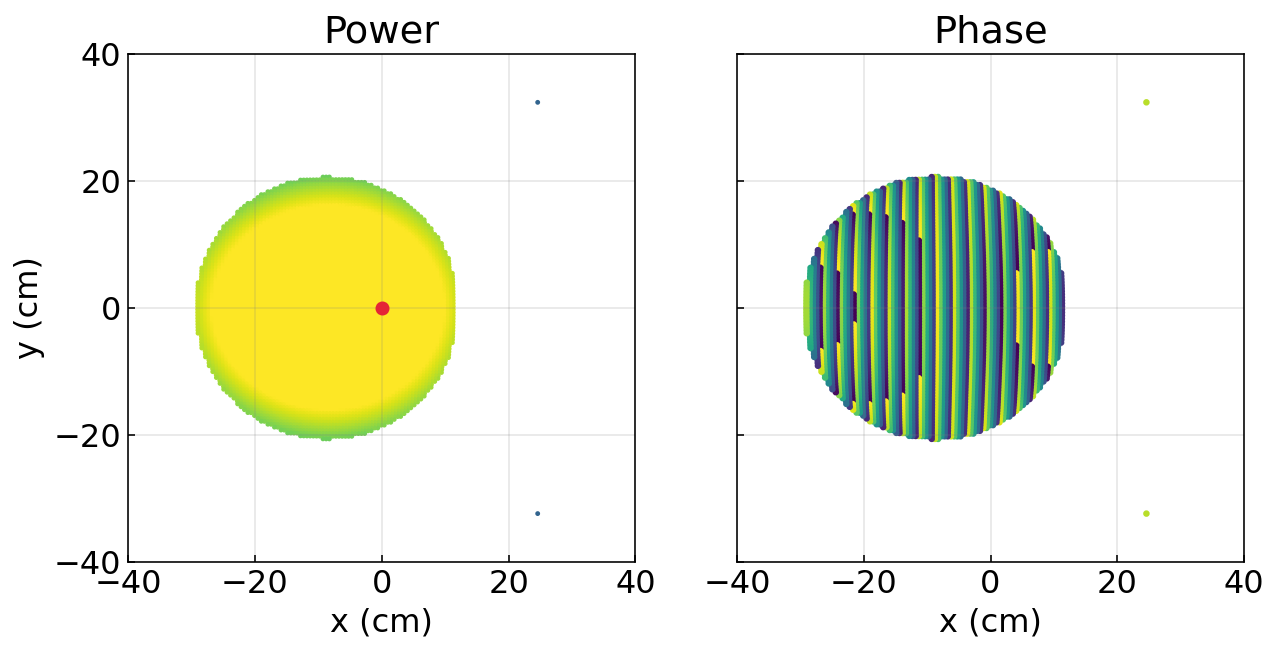

In [5]:
fig,ax = plt.subplots(1,2,figsize=(10, 5),sharey=True)

ax[1].set_title("Phase")
ax[1].scatter(out[0][xx]/1e1, out[2][xx]/1e1, s=5, c=p_sim[xx])
ax[1].set_aspect("equal")
ax[1].set_xlim(-40, 40)
ax[1].set_ylim(-40, 40)
ax[1].set_xlabel("x (cm)")
ax[1].grid()

ax[0].set_title("Power")
ax[0].plot(0,0,'o',color = red)
ax[0].scatter(out[0][xx]/1e1, out[2][xx]/1e1, s=2, c=20*np.log10(out[4][xx]/np.max(out[4][xx])),vmax=-5,vmin=-20)
ax[0].set_aspect("equal")
ax[0].set_xlim(-40, 40)
ax[0].set_ylim(-40, 40)
ax[0].set_xlabel("x (cm)")
ax[0].set_ylabel("y (cm)")
ax[0].grid()
plt.show()

In [6]:
print("The source is located at {:.2f} cm from the focal plane.".format(tele_geo.y_source/1e1))
beam_cent = [np.mean(out[0][xx]/1e1), np.mean(out[2][xx]/1e1)]
print("The center of the beam is located at ({:.2f},{:.2f})cm w.r.t the center of the window.".format(beam_cent[0],beam_cent[1]))
print("The beam angle out of the window is: {:.2f} deg.".format(90-np.rad2deg(np.arctan2(np.mean(out[9][xx]),np.mean(out[10][xx])))))
print("The beam angle out of the window is: {:.2f} deg.".format(90-np.rad2deg(np.arctan2(np.mean(out[9][xx]),np.mean(out[8][xx])))))

The source is located at 111.56 cm from the focal plane.
The center of the beam is located at (-8.63,0.00)cm w.r.t the center of the window.
The beam angle out of the window is: -0.00 deg.
The beam angle out of the window is: -15.99 deg.
